# Prep Shuffling

In [0]:
import numpy as np
X = np.array([[1., 10., 100], [2., 20., 200], [3., 30.,300]])
y = np.array([[0,10,20], [1,11,21], [2,12,22]])
print( X.shape )
print( y.shape )
print( X  )
print( y )
from sklearn.utils import shuffle
X, y = shuffle(X.T, y.T)
print("After Shuffle")
print( X.T  )
print( y.T )


(3, 3)
(3, 3)
[[  1.  10. 100.]
 [  2.  20. 200.]
 [  3.  30. 300.]]
[[ 0 10 20]
 [ 1 11 21]
 [ 2 12 22]]
After Shuffle
[[100.  10.   1.]
 [200.  20.   2.]
 [300.  30.   3.]]
[[20 10  0]
 [21 11  1]
 [22 12  2]]


In [0]:
# Our Situation: N = 4
import random
X = np.array([[1., 10., 100, 1000], [2., 20., 200, 2000], [3., 30.,300, 3000]])
y = np.array([[0,10,20,30], [1,11,21,31], [2,12,22,32] ])
print( X.shape )
print( y.shape )

permutation = np.random.permutation( X.shape[1])
print( permutation)
X_s = X.T[permutation]
y_s = y.T[permutation]
print( X_s.T )
print( y_s.T )




(3, 4)
(3, 4)
[0 1 3 2]
[[1.e+00 1.e+01 1.e+03 1.e+02]
 [2.e+00 2.e+01 2.e+03 2.e+02]
 [3.e+00 3.e+01 3.e+03 3.e+02]]
[[ 0 10 30 20]
 [ 1 11 31 21]
 [ 2 12 32 22]]


# Adding Stochastic Gradient Descent

In [0]:
import numpy as np 
import pandas as pd
from sklearn.utils import shuffle
import sys

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import metrics


   
def standardize(matrix):
    result = np.empty( matrix.shape )    
    # run through the lines    
    cols = matrix.shape[1]
    for i in range( cols ):
        col = matrix[:,i]

        mean = np.mean(col)
        std = np.std(col)

        # Handle std = 0 case
        if std < 1E-6:
          std = 1
            
        result[:,i] = np.array( (col - mean) / std  )

    return result


def sigma(z, act_func):
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')


def sigma_prime(z, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(z), np.zeros(z.shape)) # 1 if backward input >0, 0 otherwise; then diaganolize

    elif act_func == 'sigmoid':
        h = sigma(z, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(z.shape)

    else:
        raise Exception('Activation function is not defined.')

def loss(y_true, y_predicted, loss_function='mse'):
    if loss_function == 'mse':       
        return metrics.mean_squared_error( y_true, y_predicted)
    else:
        raise Exception('Loss metric is not defined.')


def get_dZ_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return (y_predicted - y)

    else:
        raise Exception('Loss metric is not defined.')
   
        
class Layer:
    def __init__(self,input_dim, output_dim, activation_function='linear'):    
        self.activation = activation_function
        self.input_dim = input_dim
        self.output_dim = output_dim 
        if input_dim > 0:
            #self.b = np.random.randn( output_dim, 1 )       
            #self.W = np.random.randn( output_dim, input_dim )
            #self.dW = np.random.randn( output_dim, input_dim )
            #self.db = np.random.randn( output_dim, 1 )
            self.b  = np.ones( (output_dim, 1) )       
            self.W  = np.ones( (output_dim, input_dim) )
            self.dW = np.ones( (output_dim, input_dim) )
            self.db = np.ones( (output_dim, 1) )
        self.a = np.zeros( (output_dim,1) )
        self.history = []
    
    def rescale_derivates(self):
        pass

    def save_state(self):
      self.last_W = self.W
      self.last_b = self.b

    def restore_state(self):
      self.W = self.last_W
      self.b = self.last_b

    def set_weight(self, W ):
        self.W = W
      
    def set_bias(self, b ):
        self.b = b
  
    def compute_activation(self, a ): 
        self.z =  np.add( np.dot(self.W, a), self.b)
        self.a =  sigma(self.z, self.activation)
    
    def save_history(self):
        self.history.append([
            np.square(self.a).sum(),
            np.square(self.W).sum(),
            np.square(self.b).sum(),   
            np.square(self.dz).sum(),                                    
            np.square(self.dW).sum(),
            np.square(self.db).sum(),            
        ])

    def get_history(self):
        return pd.DataFrame(
          self.history, 
          columns=['a', 'W', 'b','dz', 'dW', 'db']
        )  

    def print( self ):
        print(f"\n====== Layer Info =======")
        print(f"a    = {self.a}") 
        print(f"dz   = {self.dz}")                              
        print(f"dW   = {self.dW}")
        print(f"db   = {self.db}")
        print("caused...")
        print(f"W   =  {self.W}")          
        print(f"b   =  {self.b}")    
    
    
class Model:
  def __init__(self, input_dim):  
      self.history = []
      self.neural_net = []
      self.neural_net.append(Layer(0 , input_dim, 'irrelevant'))
    

  def add_layer(self, nr_neurons, activation='relu'):    
      layer_index = len(self.neural_net)
      input_dim = self.neural_net[layer_index - 1].output_dim
      new_layer = Layer( input_dim, nr_neurons, activation)
      self.neural_net.append( new_layer )
      
  
  def get_history(self):
      return pd.DataFrame(
          self.history, 
          columns=['epoch', 'train_loss', 'val_loss']
      )         

  def save_state(self):
    for layer_index in range(1,len(self.neural_net)): 
      self.neural_net[layer_index].save_state()

  def restore_state(self):
    for layer_index in range(1,len(self.neural_net)): 
      self.neural_net[layer_index].restore_state()
    
  def forward_propagation(self, input_vec ):
      self.neural_net[0].a = input_vec
      for layer_index in range(1,len(self.neural_net)):    
        _A_Prev = self.neural_net[layer_index-1].a                       
        self.neural_net[layer_index].compute_activation( _A_Prev )
        
      return  self.neural_net[layer_index].a
      
  def rescale_derivates(self):
       for layer_index in range(1,len(self.neural_net)):  
          self.neural_net[layer_index].rescale_derivates()


  def fit(self, training_data, epochs, val_data = None, early_stop=-1, doShuffle=True, batch_size=0, learning_rate=0.001, verbose=1 ):
      self.learning_rate = learning_rate
      self.history = []  
      
      X_train, y_train = training_data

      if val_data:
        X_valid, y_valid = val_data

      num_train_datum = X_train.shape[1]

      print(f"\n\nStart training for following parameters :")
      print(f" N              =  {num_train_datum}")
      print(f" Shape of X     =  {X_train.shape}")
      print(f" Shape of y     =  {y_train.shape}")
      print(f" epochs         = {epochs}")
      print(f" batch_size     =  {batch_size}")
      print(f" learning_rate  =  {learning_rate}")
      print(f" early_stop     =  {early_stop}")
      if val_data:
          print(f" N for Val Data  = {X_valid.shape[1]}")
      else:
          print(f" No validation data provided")  
      
      # Training Loop
      for epoch in range(1,epochs+1): 

          # Start to prepare the batches ...
          if batch_size:
              # Shuffle, IMPROVE, as this creats a copy..
              if doShuffle:
                X_shuffle, y_shuffle = shuffle(X_train.T, y_train.T)
              else:
                X_shuffle, y_shuffle = (X_train.T, y_train.T)
                
              # Note the transpose, to undo shuffel transpose
              X_train_batches_list = [   
                  X_shuffle.T[: , k:k+batch_size]
                  for k in range(0, num_train_datum, batch_size)]  

              y_train_batches_list = [   
                  y_shuffle.T[:, k:k+batch_size]
                  for k in range(0, num_train_datum, batch_size)]  

              nr_batches = len(X_train_batches_list)      
              for i in range( nr_batches ):
                  X_train_batch = X_train_batches_list[i]
                  y_train_batch = y_train_batches_list[i]

                  y_train_batch_predicted = model.forward_propagation( X_train_batch )
                  self.backward_propagation( y_train_batch, y_train_batch_predicted, num_train_datum, verbose = verbose - 1 )
                  self.update( learning_rate )
      
          
          else: # Training with full data set            
              y_train_predicted = model.forward_propagation( X_train )
              self.backward_propagation( y_train, y_train_predicted, num_train_datum, verbose = verbose - 1 )
              self.update( learning_rate )
                           
   

          ##  - Backpropagation for whole training set is finished
          ##  - Weigths and Biases are updated
          
          # After backpropagation
          # ... calculate the training loss
          y_train_predicted = model.forward_propagation( X_train )
          training_loss   = loss(y_train, y_train_predicted)

          # ... calculate the validation loss ( if applicable)          
          if val_data:
            y_valid_predicted = model.forward_propagation( X_valid )
            validation_loss   = loss(y_valid, y_valid_predicted)
          else:
            validation_loss = -1

          # ... add result to the histoty
          self.history.append( [epoch, training_loss, validation_loss])

          # ...and finally check, if early_stop applies
          if (epoch > 10)  and (early_stop > 0):            
            past_loss   = self.history[epoch-6][1] 
            if (abs(training_loss - past_loss)) < early_stop:
              print(f"Early stop in after epoch {epoch} with training-loss  {actual_train_loss}")
              print(f"Early stop in after epoch {epoch} with validation-loss  {actual_val_loss}")          
              print(f"   Prev Loss ({epoch-5}) : {past_loss} [Delta: { abs(actual_train_loss-past_loss) }]")
              break   
            
          # If requested, print result of this round
          if (verbose > 0):
            print(f"Epoch {epoch}: Train.-Loss   = { training_loss  }")
            print(f"Epoch {epoch}: Val-Loss      = { validation_loss  }")
            print(f"Epoch {epoch}: Finished")

          ##### end of fit loop 
      return (training_loss, validation_loss)
        
  def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):   
    nr_layers = len(self.neural_net)
    for layer_index in range(nr_layers-1,0,-1):
        if layer_index+1 == nr_layers: # if output layer

            dZ = np.multiply(get_dZ_from_loss(y, y_predicted, metric), 
                             sigma_prime(
                                self.neural_net[layer_index].a, 
                                self.neural_net[layer_index].activation)
            )
        
        else: 
            dZ = np.multiply(
                   np.dot(
                       self.neural_net[layer_index+1].W.T, 
                       dZ), 
                   sigma_prime(
                         self.neural_net[layer_index].a, 
                         self.neural_net[layer_index].activation)
                   )
           
        
        dW = np.dot(dZ, self.neural_net[layer_index-1].a.T) / num_train_datum
        db = np.sum(dZ, axis=1, keepdims=True) / num_train_datum

        # Manage Gradients
        self.neural_net[layer_index].dW = dW 
        self.neural_net[layer_index].db = db 

        self.neural_net[layer_index].dz = dZ # just for logging
        if (verbose > 0):
          print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
          print(f"dZ      =  {dZ}")          
          print(f"dW      =  {dW}")
          print(f"db     =  {db}")
          print(f"A           = {self.neural_net[layer_index].a}") 
          print(f"A prev lay  = {self.neural_net[layer_index-1].a}") 
             

  def update( self, learning_rate ):
      nr_layers = len(self.neural_net)
      for layer_index in range(1,nr_layers):        
          self.neural_net[layer_index].set_weight( self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW )
          self.neural_net[layer_index].set_bias(  self.neural_net[layer_index].b  - learning_rate * self.neural_net[layer_index].db  )
          self.neural_net[layer_index].save_history( )
    


  def summary(self):
      print("MODEL SUMMARY")
      for layer_index in range(len(self.neural_net)):        
        self.neural_net[layer_index].print()
        
      print("FINISHED MODEL SUMMARY")
      
        


# Exploding Gradients

Shapes of created data :
Shape of X :(5, 2)
Shape of y :(5, 1)
[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]]
[[ 3.]
 [ 7.]
 [11.]
 [15.]
 [19.]]


Start training for following parameters :
 N              =  5
 Shape of X     =  (2, 5)
 Shape of y     =  (1, 5)
 epochs         = 1000
 batch_size     =  0
 learning_rate  =  0.01
 early_stop     =  -1
 No validation data provided

Result training_loss = 0.000416534439797355
Prediction vs Real:
y = [[ 3.  7. 11. 15. 19.]]
y_pred = [[ 3.03496133  7.02207584 11.00919034 14.99630484 18.98341934]]


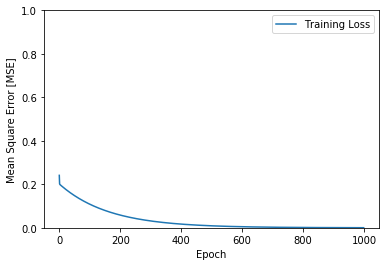

History of Layer 1


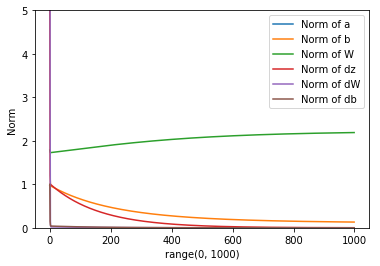


====== Layer Info =======
a    = [[ 3.03496133  7.02207584 11.00919034 14.99630484 18.98341934]]
dz   = [[ 0.03506967  0.02214424  0.00921882 -0.00370661 -0.01663204]]
dW   = [[-0.00560763  0.00361119]]
db   = [[0.00921882]]
caused...
W   =  [[1.31523681 0.67832044]]
b   =  [[0.36308364]]
New weight : [[1.31635833 0.67759821]]
New weight : [[1.31624028 0.67767423]]
New weight : [[1.31612222 0.67775026]]
New weight : [[1.31600417 0.67782628]]
New weight : [[1.31588611 0.67790231]]
New weight : [[1.31576805 0.67797833]]
New weight : [[1.31565    0.67805436]]
New weight : [[1.31553194 0.67813038]]
New weight : [[1.31541389 0.67820641]]
New weight : [[1.31529583 0.67828243]]
New weight : [[1.31517778 0.67835846]]
New weight : [[1.31505972 0.67843448]]
New weight : [[1.31494167 0.67851051]]
New weight : [[1.31482361 0.67858653]]
New weight : [[1.31470556 0.67866256]]
New weight : [[1.3145875  0.67873858]]
New weight : [[1.31446945 0.67881461]]
New weight : [[1.31435139 0.67889063]]
New wei

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


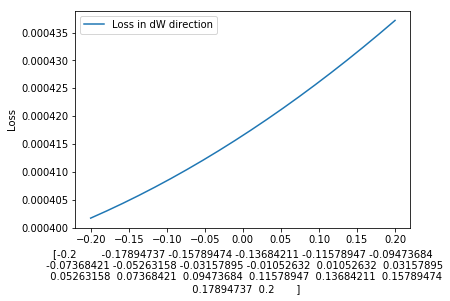

            a         W         b        dz         dW        db
0  880.000000  1.786100  0.980100  5.000000  61.000000  1.000000
1  790.406000  1.740700  0.972590  1.206000   3.000400  0.144400
2  771.071273  1.731308  0.967839  1.011273   0.157107  0.058177
3  766.786833  1.729873  0.963716  0.995713   0.025127  0.043996
4  765.828930  1.730210  0.959749  0.989107   0.020582  0.040907
              a         W         b        dz        dW        db
995  764.981935  2.189571  0.132099  0.002148  0.000046  0.000087
996  764.981984  2.189670  0.132031  0.002135  0.000045  0.000087
997  764.982033  2.189769  0.131964  0.002122  0.000045  0.000086
998  764.982082  2.189868  0.131897  0.002109  0.000045  0.000086
999  764.982131  2.189966  0.131830  0.002096  0.000044  0.000085


In [3]:
import numpy as np
def load_random_data_D (N = 5, delta=0.0):
    """ This can be run with just one (output) layer. 
    For N=10 use  5000 epochs and learning_rate=0.005, no early_stop, since
    training progress is slow and danger of exploding gradients, if learning_rate
    is higher
    """
    X = np.arange(1,2*N+1).reshape(N,2) + delta*np.random.rand(N,2)
    x1 = X[:,0]
    x2 = X[:,1]    
    y = np.array([x1 + x2]); 
    print("Shapes of created data :")
    print(f"Shape of X :{X.shape}")
    print(f"Shape of y :{y.T.shape}")
    
    return (X, y.T)

(X,y) = load_random_data_D(5, delta=0)
print(X)
print(y)

X_S = standardize(X)

input_dim = X.shape[1]
output_dim = y.shape[1]

model = Model( input_dim )
model.add_layer( output_dim, 'linear' )



training_loss, validation_loss =model.fit( (X.T,y.T), 1000, batch_size = 0, early_stop = -1, learning_rate = 0.01, verbose= 0)
print(f"\nResult training_loss = {training_loss}")
print("Prediction vs Real:")
print(f"y = {y.T}")
print(f"y_pred = {model.forward_propagation(X.T)}")

history = model.get_history()

plt.figure()
plt.plot(history['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MSE]')
plt.ylim([0,1])  
plt.legend()
plt.show()


for layer_index in range(1,len(model.neural_net)):
  print(f"History of Layer { layer_index }")
  history = model.neural_net[layer_index].get_history()
  epochs = len(history)
  plt.figure()
  plt.plot(history['a'], label='Norm of a')
  plt.plot(history['b'], label='Norm of b')
  plt.plot(history['W'], label='Norm of W')
  plt.plot(history['dz'], label='Norm of dz')
  plt.plot(history['dW'], label='Norm of dW')
  plt.plot(history['db'], label='Norm of db')
  plt.xlabel( range(0,epochs) )
  plt.ylabel('Norm')
  plt.ylim([0,5])  
  plt.legend()
  plt.show()
  model.neural_net[layer_index].print()

# Plotting in direction of dw
layer = model.neural_net[len(model.neural_net) -1]
original_weight = layer.W

y_values = []
x_values = np.linspace(-0.2, 0.2, 20)
for x in x_values:
  new_weight = original_weight + x * layer.dW
  print(f"New weight : {new_weight}")
  layer.set_weight(new_weight)
  y_predicted = model.forward_propagation( X.T )
  cost = loss(y.T, y_predicted)
  y_values.append([cost])

plt.figure()
plt.xlabel( x_values )
plt.plot(x_values, y_values, label='Loss in dW direction')
plt.ylabel('Loss')
#plt.ylim([0,0.5])  
plt.legend()
plt.show()


print( history.head(5) )
print( history.tail(5) )

# Internal xxx

In [0]:
x = np.array([1,2,3])
print( x*2 )

[2 4 6]
